In [117]:
import json
import os
import re
import time
import uuid
from collections import Counter, defaultdict
from dataclasses import dataclass
from datetime import datetime
from typing import Dict, List

import matplotlib.pyplot as plt
import requests
from tqdm.notebook import tqdm

In [118]:
CLIENT_ID = "qeyx02kvx8uffv4std0did44iyoj35"
CLIENT_SECRET = "s9jf674kb2ekkqqyv1nrs8uftnxuum"
STREAMER_ID = "14371185" # https://www.twitch.tv/northernlion

In [119]:
@dataclass
class Comment:
    commenter: str
    createdAt: datetime
    contentOffsetSeconds: int
    message: str
    video_id: str

In [120]:
def get_access_token():
    app_access_token_response = requests.post(
        "https://id.twitch.tv/oauth2/token",
        params={
            "client_id": CLIENT_ID,
            "client_secret": CLIENT_SECRET,
            "grant_type": "client_credentials",
        }
    )

    expires_in = app_access_token_response.json()["expires_in"]
    expiration_time_ = time.time() + expires_in
    return app_access_token_response.json()["access_token"], expiration_time_

app_access_token, expiration_time = get_access_token()

In [121]:
base_api_url = "https://api.twitch.tv/helix" 
def twitch_api_get(url, params=None):
    global app_access_token, expiration_time
    if time.time() > expiration_time:
        print("Refreshing token")
        app_access_token, expiration_time = get_access_token()
    full_url = os.path.join(base_api_url, url)
    return requests.get(
        full_url,
        params=params,
        headers={
            "Client-Id": CLIENT_ID,
            "Authorization": f"Bearer {app_access_token}",
        }
    )

In [122]:
videos = twitch_api_get("videos", params={"user_id": STREAMER_ID, "type": "archive"})

In [124]:
# util functions

def get_datetime(date_string):
    return datetime.strptime(date_string, "%Y-%m-%dT%H:%M:%S.%fZ"
                             if "." in date_string
                             else "%Y-%m-%dT%H:%M:%SZ")

def get_vod_link_from_comment(comment: Comment, offset=0) -> str:
    return f"https://twitch.tv/videos/{comment.video_id}?t={comment.contentOffsetSeconds + offset}s"

headers = {
    "Client-ID": "kd1unb4b3q4t58fwlpcbzcbnm76a8fp",
    "Accept": "application/vnd.twitchtv.v5+json",
    'X-Device-Id': uuid.uuid4().hex,
}

def gql(query: str):
    response = requests.post("https://gql.twitch.tv/gql", json={"query": query}, headers=headers)
    if response.status_code != 200 or "errors" in response.json():
        print(response.json())
        print(response.request.body)
        raise RuntimeError("GQL request failed")
    return response

In [125]:
DURATION_RE = re.compile(r"(?:(\d+)h)?(?:(\d+)m)?(?:(\d+)s)?")

result: Dict[str, List[Comment]] = defaultdict(list)
for video in tqdm(videos.json()["data"]):
    res = []
    has_next_page = True
    cursor = None
    video_id = video["id"]
    duration_match = DURATION_RE.match(video["duration"])
    duration = sum(int(x or 0) * 60 ** i for i, x in enumerate(reversed(duration_match.groups())))
    
    with tqdm(total=duration, unit="s", desc=video['created_at']) as video_bar:
        if os.path.isfile(f"data/{video['created_at']}.json"):
            with open(os.path.join("data", f"{video['created_at']}.json")) as f:
                objs = json.load(f)
                result[video["created_at"]] = [
                    Comment(comment["commenter"],
                            datetime.fromisoformat(comment["createdAt"]),
                            comment["contentOffsetSeconds"],
                            comment["message"],
                            comment["video_id"],
                            )
                    for comment in objs
                ]
                video_bar.update(video_bar.total)
                continue
        while has_next_page:
            query = f"""
                query {{
                    video(id: "{video_id}") {{
                        comments{f'(after: "{cursor}")' if cursor else ''} {{
                            edges {{
                                cursor
                                node {{
                                    commenter {{
                                        displayName
                                        login
                                    }}
                                    createdAt
                                    contentOffsetSeconds
                                    message {{
                                        fragments {{
                                            text
                                        }}
                                    }}
                                }}
                            }}
                            pageInfo {{
                                hasNextPage
                            }}
                        }}
                    }}
                }}
            """
            response = gql(query)
            comments = response.json()["data"]["video"]["comments"]
            has_next_page = comments["pageInfo"]["hasNextPage"]
            if len(comments["edges"]) == 0:
                print(response.json())
                raise IOError("Bad.")
            for comment in comments["edges"]:
                res.append(Comment(
                    commenter=comment["node"]["commenter"]["displayName"] if comment["node"]["commenter"] else "UNKNOWN",
                    createdAt=get_datetime(comment["node"]["createdAt"]),
                    contentOffsetSeconds=comment["node"]["contentOffsetSeconds"],
                    message=comment["node"]["message"]["fragments"][0]["text"],
                    video_id=video_id,
                ))
            cursor = comments["edges"][-1]["cursor"]
            video_bar.update(comments["edges"][-1]["node"]["contentOffsetSeconds"] - video_bar.n)
        result[video["created_at"]] = res

        

  0%|          | 0/20 [00:00<?, ?it/s]

2023-05-15T16:07:29Z:   0%|          | 0/16692 [00:00<?, ?s/s]

2023-05-12T16:09:48Z:   0%|          | 0/17829 [00:00<?, ?s/s]

2023-05-11T16:02:39Z:   0%|          | 0/17800 [00:00<?, ?s/s]

2023-05-10T16:04:31Z:   0%|          | 0/18096 [00:00<?, ?s/s]

2023-05-09T16:03:09Z:   0%|          | 0/18542 [00:00<?, ?s/s]

2023-05-08T15:09:16Z:   0%|          | 0/21263 [00:00<?, ?s/s]

2023-05-05T16:04:25Z:   0%|          | 0/18154 [00:00<?, ?s/s]

2023-05-04T16:05:43Z:   0%|          | 0/17307 [00:00<?, ?s/s]

2023-05-03T16:07:15Z:   0%|          | 0/17994 [00:00<?, ?s/s]

KeyboardInterrupt: 

In [29]:
# Comments by coolseel

c = Counter()
[(c, get_vod_link_from_comment(c, -10)) for cs in result.values() for c in cs if c.commenter == "coolseel"]

[(Comment(commenter='coolseel', createdAt=datetime.datetime(2023, 5, 15, 16, 16, 30, 175000), contentOffsetSeconds=540, message='t2t Pog', video_id='1820620398'),
  'https://twitch.tv/videos/1820620398?t=530s'),
 (Comment(commenter='coolseel', createdAt=datetime.datetime(2023, 5, 15, 16, 17, 33, 921000), contentOffsetSeconds=604, message='owned', video_id='1820620398'),
  'https://twitch.tv/videos/1820620398?t=594s'),
 (Comment(commenter='coolseel', createdAt=datetime.datetime(2023, 5, 12, 18, 45, 17, 148000), contentOffsetSeconds=9327, message='!docket', video_id='1818037433'),
  'https://twitch.tv/videos/1818037433?t=9317s'),
 (Comment(commenter='coolseel', createdAt=datetime.datetime(2023, 5, 12, 18, 45, 24, 742000), contentOffsetSeconds=9335, message='midnight suns Pog', video_id='1818037433'),
  'https://twitch.tv/videos/1818037433?t=9325s'),
 (Comment(commenter='coolseel', createdAt=datetime.datetime(2023, 5, 12, 18, 56, 36, 992000), contentOffsetSeconds=10007, message='POGCRAZY'

In [126]:
# Dump comments to json

import json

os.makedirs("data", exist_ok=True)
for k, v in result.items():
    with open(f"data/{k}.json", "w") as f:
        json.dump(v, f, indent=2, default=lambda o: o.isoformat() if isinstance(o, datetime) else o.__dict__)

In [127]:
def get_video_chapters(video_id: str) -> list:
    has_next_page = True
    cursor = None
    chapters = []
    while has_next_page:
        query = f"""
            query {{
                video(id: "{video_id}") {{
                    moments(momentRequestType: VIDEO_CHAPTER_MARKERS {f', after: "{cursor}"' if cursor else ''}) {{
                        edges {{
                            cursor
                            node {{
                                description
                                positionMilliseconds
                            }}
                        }}
                        pageInfo {{
                            hasNextPage
                        }}
                    }}
                }}
            }}
        """
        response = gql(query).json()['data']
        cursor = response['video']['moments']['edges'][-1]['cursor']
        has_next_page = response['video']['moments']['pageInfo']['hasNextPage']
        chapters.extend(e['node'] for e in response['video']['moments']['edges'])
    return chapters

Top bits:
https://twitch.tv/videos/1820620398?t=1970s -- 39 occurrences
https://twitch.tv/videos/1818037433?t=250s -- 34 occurrences
https://twitch.tv/videos/1811229683?t=1270s -- 29 occurrences
https://twitch.tv/videos/1817191098?t=12070s -- 25 occurrences
https://twitch.tv/videos/1817191098?t=1950s -- 21 occurrences
https://twitch.tv/videos/1811229683?t=5970s -- 20 occurrences
https://twitch.tv/videos/1817191098?t=17610s -- 19 occurrences
https://twitch.tv/videos/1816370668?t=1470s -- 19 occurrences
https://twitch.tv/videos/1812066974?t=4370s -- 16 occurrences
https://twitch.tv/videos/1817191098?t=250s -- 15 occurrences
https://twitch.tv/videos/1812066974?t=15990s -- 15 occurrences
https://twitch.tv/videos/1811229683?t=90s -- 15 occurrences
https://twitch.tv/videos/1820620398?t=2530s -- 13 occurrences
https://twitch.tv/videos/1818037433?t=9650s -- 13 occurrences
https://twitch.tv/videos/1815532565?t=3430s -- 13 occurrences
https://twitch.tv/videos/1811229683?t=1350s -- 13 occurrences

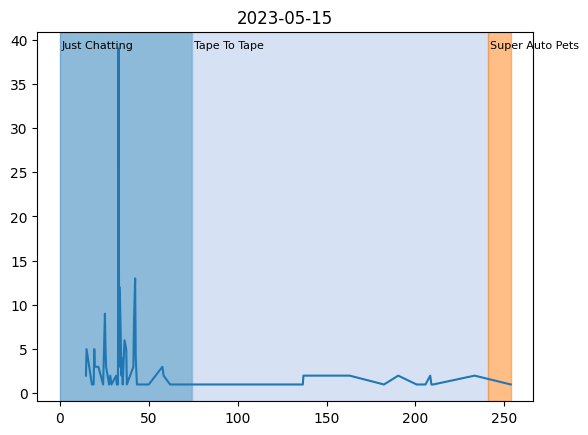

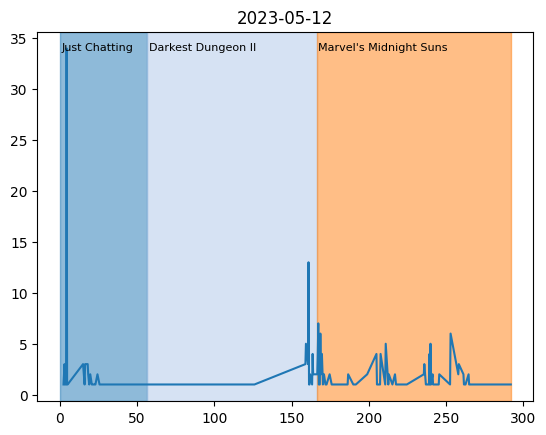

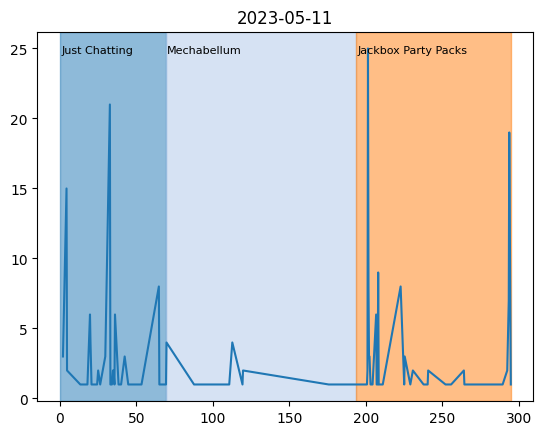

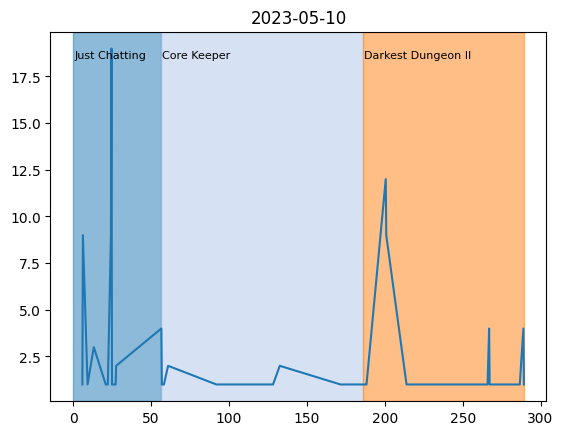

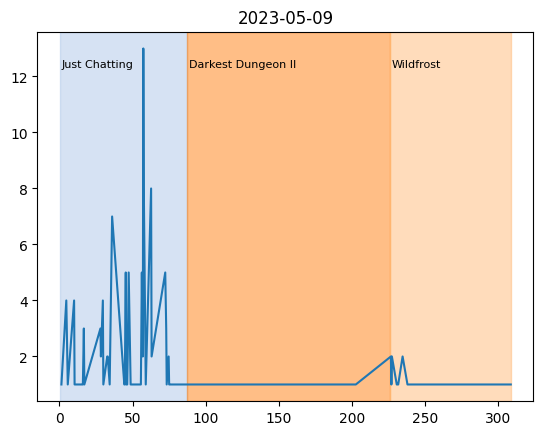

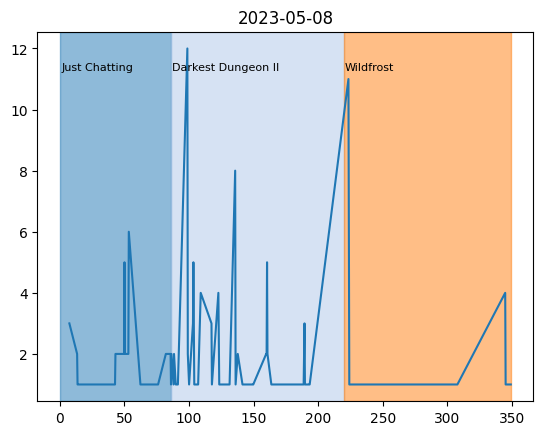

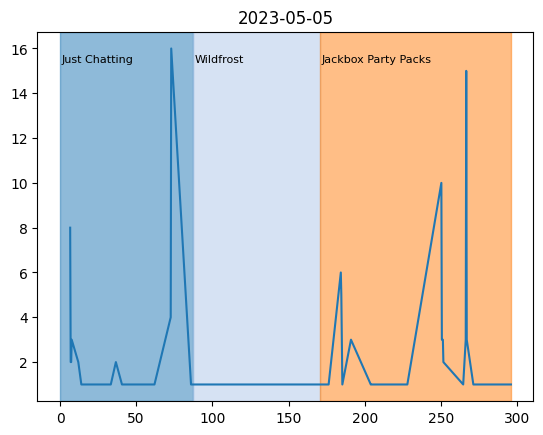

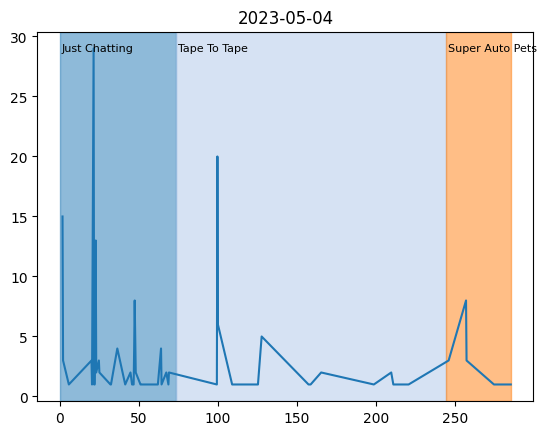

In [116]:
# Plots, best bits etc.
categories = {
    "any": [""],
    "pogged": ["Pog", "POGCRAZY", "LETSGO"],
    "scary": ["monkaS"],
    "+2": ["+2"],
    "-2": ["-2"],
    "controversial": ["+2", "-2"],
    "end": ["ty ty ty"],
    "horny": ["COCKA"],
    "shocking": ["Cereal"],
    "BatChest": ["BatChest"],
}
keywords = categories["BatChest"]
bucket_width = 20
overall_counter = Counter()
for k, v in result.items():
    video_id = v[0].video_id
    cmap = plt.get_cmap('tab20')
    c = Counter(c.contentOffsetSeconds // bucket_width for c in v if any(k in c.message for k in keywords))
    overall_counter += {(bit[0], video_id): bit[1] for bit in c.items()}
    keys = sorted(c.keys())
    x = [k * bucket_width / 60 for k in keys]
    y = [c[k] for k in keys]
    chapters = get_video_chapters(video_id)
    fig, ax = plt.subplots(1, 1)
    plt.title(k[:len('YYYY-MM-DD')])
    plt.plot(x, y)
    ymax = ax.get_ylim()[1]
    for i, chapter in enumerate(chapters):
        chapter_start_min = chapter['positionMilliseconds'] / 1000 / 60
        chapter_end_min = chapters[i + 1]['positionMilliseconds'] / 1000 / 60 if i + 1 < len(chapters) else max(x)
        if chapter_end_min - chapter_start_min < 10:
            continue
        plt.axvspan(chapter_start_min, chapter_end_min, alpha=0.5, color=cmap(i), zorder=-10)
        plt.text(chapter_start_min + 1, ymax - 1, chapter['description'], fontsize=8, verticalalignment='top')
print(f"Top bits:")
for bit in overall_counter.most_common(20):
    print(f"https://twitch.tv/videos/{bit[0][1]}?t={bit[0][0] * bucket_width - 10}s -- {bit[1]} occurrences")

TypeError: unsupported operand type(s) for /: 'range' and 'int'